##### 对shuffle_50k训练数据进行切分，45k用作训练，剩下的用来验证

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:45000]
vali = data[45000:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1 = weight_variable([5, 5, 18, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# second convolutional layer
w_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])

# densely connected layer
w_fc1 = weight_variable([8*8*64, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([1024, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.RMSPropOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
for i in range(150000):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
    train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(temp_loss)
    vali_Eval.append(vali_accuracy)
    train_Eval.append(train_accuracy)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (45000, 18449)
The shape of vali is  (5989, 18449)
step 0, train accuracy 0.0664062, train loss 2649.84
step 200, train accuracy 0.40625, train loss 769.116
step 400, train accuracy 0.394531, train loss 569.605
step 600, train accuracy 0.445312, train loss 591.692
step 800, train accuracy 0.441406, train loss 510.476
step 1000, train accuracy 0.46875, train loss 447.95
step 1200, train accuracy 0.453125, train loss 479.591
step 1400, train accuracy 0.507812, train loss 412.089
step 1600, train accuracy 0.507812, train loss 415.899
step 1800, train accuracy 0.5, train loss 411.443
step 2000, train accuracy 0.511719, train loss 443.25
step 2200, train accuracy 0.457031, train loss 421.819
step 2400, train accuracy 0.492188, train loss 439.51
step 2600, train accuracy 0.523438, train loss 374.583
step 2800, train accuracy 0.550781, train loss 417.672
step 3000, train accuracy 0.503906, train loss 394.631
step 3200, train accuracy 0.554688, train loss 322.002
step 34

KeyboardInterrupt: 

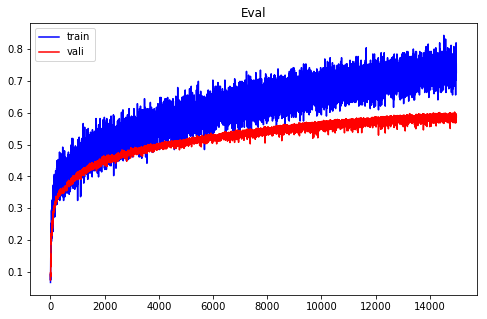

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

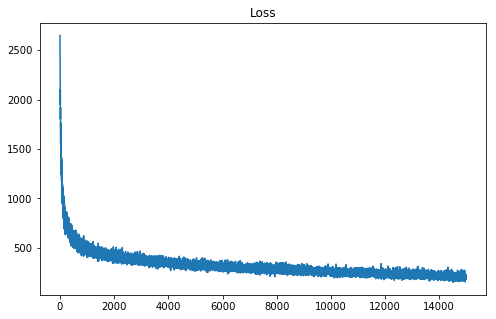

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

* fc1层4096个节点
* 优化算法：RMSProp

In [1]:
# start tensorflow interactiveSession                                
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:45000]
vali = data[45000:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1 = weight_variable([5, 5, 18, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# second convolutional layer
w_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])

# densely connected layer
w_fc1 = weight_variable([8*8*64, 4096])
b_fc1 = bias_variable([4096])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([4096, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.RMSPropOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
for i in range(150000):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
    train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(temp_loss)
    vali_Eval.append(vali_accuracy)
    train_Eval.append(train_accuracy)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (45000, 18449)
The shape of vali is  (5989, 18449)
step 0, train accuracy 0.0703125, vali accuracy 0.0819836, train loss 3734.98
step 200, train accuracy 0.3125, vali accuracy 0.289865, train loss 2296.46
step 400, train accuracy 0.390625, vali accuracy 0.35799, train loss 1102.08
step 600, train accuracy 0.507812, vali accuracy 0.418601, train loss 623.407
step 800, train accuracy 0.496094, vali accuracy 0.449491, train loss 568.275
step 1000, train accuracy 0.519531, vali accuracy 0.472533, train loss 561.689
step 1200, train accuracy 0.546875, vali accuracy 0.489731, train loss 420.834
step 1400, train accuracy 0.566406, vali accuracy 0.500084, train loss 446.518
step 1600, train accuracy 0.582031, vali accuracy 0.504091, train loss 388.62
step 1800, train accuracy 0.601562, vali accuracy 0.527467, train loss 322.14
step 2000, train accuracy 0.671875, vali accuracy 0.517616, train loss 289.019
step 2200, train accuracy 0.65625, vali accuracy 0.530306, train lo

KeyboardInterrupt: 

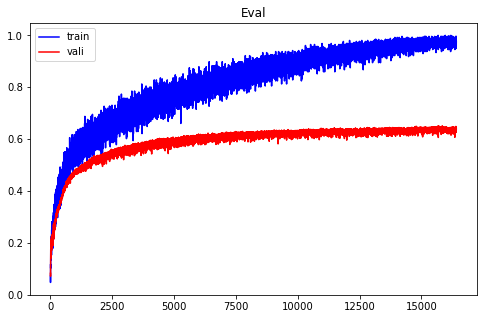

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

In [3]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.48      0.47      0.47       361
          1       0.38      0.43      0.40       322
          2       0.56      0.45      0.50       362
          3       0.42      0.54      0.47       351
          4       0.46      0.37      0.41       378
          5       0.57      0.60      0.59       365
          6       0.69      0.83      0.75       356
          7       0.57      0.61      0.59       395
          8       0.70      0.68      0.69       346
          9       0.34      0.35      0.34       338
         10       0.83      0.92      0.88       326
         11       0.66      0.72      0.69       305
         12       0.89      0.76      0.82       390
         13       0.84      0.63      0.72       356
         14       0.81      0.80      0.80       309
         15       0.85      0.85      0.85       371
         16       0.99      0.97      0.98       358

avg / total       0.65      0.64      0.64  

* 4个3*3的卷积层

In [1]:
# start tensorflow interactiveSession                              线上   0.68
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:45000]
vali = data[49000:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 18, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 4096])
b_fc1 = bias_variable([4096])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([4096, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.RMSPropOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
for i in range(30000):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
    train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(temp_loss)
    vali_Eval.append(vali_accuracy)
    train_Eval.append(train_accuracy)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (45000, 18449)
The shape of vali is  (1989, 18449)
step 0, train accuracy 0.078125, vali accuracy 0.0613374, train loss 3554.09
step 200, train accuracy 0.179688, vali accuracy 0.171443, train loss 3342.04
step 400, train accuracy 0.238281, vali accuracy 0.191554, train loss 3112.47
step 600, train accuracy 0.234375, vali accuracy 0.2182, train loss 3127.49
step 800, train accuracy 0.230469, vali accuracy 0.208648, train loss 3103.7
step 1000, train accuracy 0.386719, vali accuracy 0.311212, train loss 2228.68
step 1200, train accuracy 0.472656, vali accuracy 0.397185, train loss 668.577
step 1400, train accuracy 0.503906, vali accuracy 0.438411, train loss 563.911
step 1600, train accuracy 0.558594, vali accuracy 0.490699, train loss 358.859
step 1800, train accuracy 0.539062, vali accuracy 0.499246, train loss 457.887
step 2000, train accuracy 0.601562, vali accuracy 0.519859, train loss 359.756
step 2200, train accuracy 0.628906, vali accuracy 0.536451, train 

step 20800, train accuracy 1, vali accuracy 0.718451, train loss 2.34078
step 21000, train accuracy 0.996094, vali accuracy 0.701357, train loss 11.9652
step 21200, train accuracy 0.996094, vali accuracy 0.711413, train loss 20.9219
step 21400, train accuracy 0.992188, vali accuracy 0.709904, train loss 24.2649
step 21600, train accuracy 0.992188, vali accuracy 0.714932, train loss 19.9634
step 21800, train accuracy 1, vali accuracy 0.713927, train loss 3.06917
step 22000, train accuracy 1, vali accuracy 0.71644, train loss 3.25503
step 22200, train accuracy 0.992188, vali accuracy 0.713424, train loss 34.8738
step 22400, train accuracy 0.992188, vali accuracy 0.712921, train loss 20.5753
step 22600, train accuracy 1, vali accuracy 0.720965, train loss 3.16897
step 22800, train accuracy 1, vali accuracy 0.715938, train loss 3.99126
step 23000, train accuracy 0.992188, vali accuracy 0.724987, train loss 35.2923
step 23200, train accuracy 0.996094, vali accuracy 0.715435, train loss 2.86

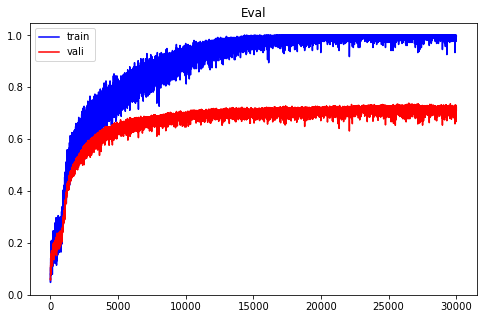

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

In [3]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.55      0.63      0.59       115
          1       0.60      0.50      0.55       107
          2       0.70      0.63      0.66       130
          3       0.55      0.56      0.55       118
          4       0.52      0.40      0.46       141
          5       0.64      0.66      0.65       122
          6       0.87      0.88      0.88       121
          7       0.64      0.70      0.67       136
          8       0.77      0.78      0.77       117
          9       0.39      0.46      0.42        97
         10       0.90      0.90      0.90       108
         11       0.79      0.76      0.78       100
         12       0.89      0.86      0.87       112
         13       0.79      0.81      0.80       114
         14       0.92      0.91      0.91       107
         15       0.84      0.91      0.87       138
         16       0.99      0.98      0.99       106

avg / total       0.72      0.72      0.72  

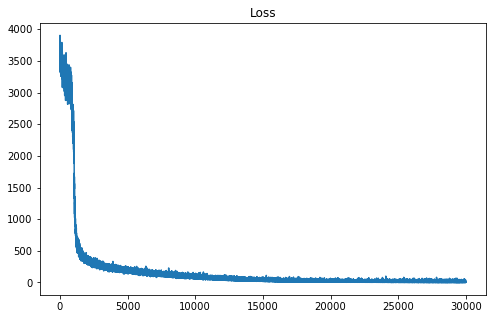

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [1]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s1 = f['sen1']
test_s2 = f['sen2']

test = []
for i in range(0,test_s1.shape[0]):
    temp1 = test_s1[i].flatten()
    temp2 = test_s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    test.append(temp)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

out.to_csv('4_conv_2_fc_RSMProp.csv', index = False, header = False)

NameError: name 'np' is not defined

* 损失函数加入正则化项
* 分类效果并没有提高，说明原先网络结构有待加强
* 但是从学习曲线可以看出正则化项的加入确实减轻了过拟合

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:45000]
vali = data[49000:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 18, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# third convolutional layer
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_pool3 = max_pool_2x2(h_conv3_2)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 8192])
b_fc1 = bias_variable([8192])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc3 = weight_variable([8192, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.RMSPropOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
for i in range(30000):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
    train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(temp_loss)
    vali_Eval.append(vali_accuracy)
    train_Eval.append(train_accuracy)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))


The shape of train is  (45000, 18449)
The shape of vali is  (1989, 18449)
step 0, train accuracy 0.0703125, vali accuracy 0.0553042, train loss 3836.11
step 200, train accuracy 0.0976562, vali accuracy 0.0703871, train loss 3723.28
step 400, train accuracy 0.1875, vali accuracy 0.106083, train loss 3352.56
step 600, train accuracy 0.160156, vali accuracy 0.104072, train loss 3465.39
step 800, train accuracy 0.105469, vali accuracy 0.105581, train loss 3691.04
step 1000, train accuracy 0.0859375, vali accuracy 0.0975365, train loss 3771.63
step 1200, train accuracy 0.0859375, vali accuracy 0.104575, train loss 3771.63


KeyboardInterrupt: 

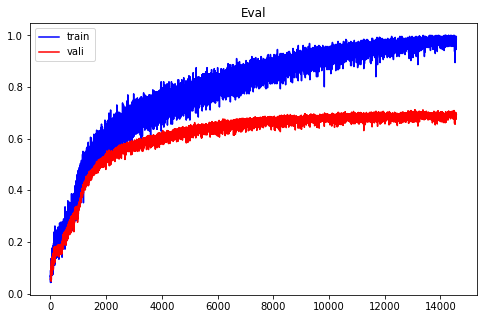

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

In [3]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.47      0.60      0.52       115
          1       0.52      0.42      0.47       107
          2       0.67      0.66      0.66       130
          3       0.50      0.49      0.50       118
          4       0.49      0.48      0.49       141
          5       0.60      0.60      0.60       122
          6       0.86      0.93      0.89       121
          7       0.62      0.70      0.66       136
          8       0.80      0.73      0.76       117
          9       0.38      0.35      0.37        97
         10       0.88      0.91      0.89       108
         11       0.78      0.76      0.77       100
         12       0.91      0.79      0.84       112
         13       0.82      0.81      0.81       114
         14       0.92      0.91      0.91       107
         15       0.87      0.91      0.89       138
         16       0.98      0.98      0.98       106

avg / total       0.71      0.71      0.71  

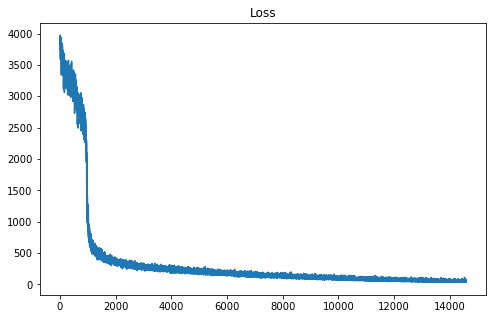

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()